In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE # determines how many images will be included in each batch
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

(256, 256, 3)


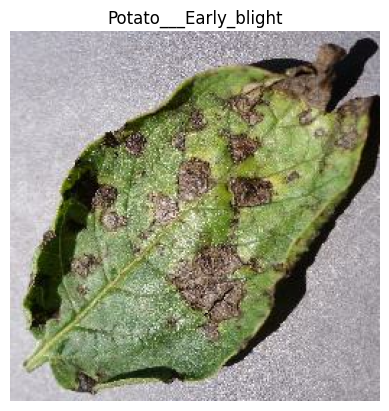

In [10]:
import matplotlib.pyplot as plt

# Get one batch
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)  # Print the shape of the first image in the batch

    # Visualize this image
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Corrected "unit8" to "uint8"
    plt.axis('off')  
    plt.title(class_names[label_batch[0]])
    plt.show() 



# to split our data into training and testing we need to Calculate the number of batches to skip
train_size = int(0.8 * len(dataset))  # 80% for training
train_dataset = dataset.take(train_size)  # Take the first 80% for training
test_dataset = dataset.skip(train_size)    # Skip the first 80% for testing

In [11]:
#split pour data set to training and testing
#80%==>training
#20%==> 10% validation,10% test
train_size=0.8

len(dataset)*train_size

54.400000000000006

In [12]:
#so for the training we will take the first 54
train_dataset=dataset.take(54)


In [13]:
test_dataset=dataset.skip(54) #  skipping the first 54 batches like arr[54:] 

len(test_dataset)

14

In [14]:
val_size=0.1 #10%
len(dataset)*val_size

6.800000000000001

In [15]:
val_datset=test_dataset.take(6)

In [16]:
test_dataset=test_dataset.skip(6)

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    # Check that the splits add up to 1
    assert train_split + val_split + test_split == 1, "Splits must sum to 1"
    
    ds_size = len(ds)  # Get the total size of the dataset
    train_size = int(train_split * ds_size)  # Calculate the number of training samples
    val_size = int(val_split * ds_size)      # Calculate the number of validation samples
    
    # Shuffle the dataset if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=ds_size)
    
    train_ds = ds.take(train_size)  # Take the first portion for training
    val_ds = ds.skip(train_size).take(val_size)  # Take the next portion for validation
    test_ds = ds.skip(train_size + val_size)  # Take the remaining portion for testing
    
    return train_ds, val_ds, test_ds


In [18]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

1. **`cache()`**:
   - This method caches the dataset in memory after the first epoch. If the dataset fits in memory, caching can significantly speed up training because the data won't need to be reloaded from disk during subsequent epochs.

2. **`shuffle(buffer_size)`**:
   - This method shuffles the dataset. The `buffer_size` parameter specifies how many elements from the dataset should be randomly sampled for shuffling. A larger buffer size means better randomness. For example, `shuffle(1000)` means the dataset will be shuffled using a buffer of 1000 elements.

3. **`prefetch(buffer_size)`**:
   - This method allows for asynchronous data loading. While the model is training on the current batch, TensorFlow can prepare the next batch in the background. Using `tf.data.AUTOTUNE` allows TensorFlow to automatically determine the optimal prefetch buffer size based on available resources, which helps improve training speed.

### Benefits:
- **Performance Improvement**: These optimizations can significantly enhance the training performance of your model by reducing the time spent on data loading and preprocessing.
- **Better Resource Utilization**: By caching and prefetching, you utilize the CPU and GPU more effectively, leading to faster overall training times.



In [19]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Define a Sequential model that includes resizing and rescaling steps
resize_and_rescale = tf.keras.Sequential([
    # Resize all input images to the target IMAGE_SIZE, ensuring consistent dimensions
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  
    
    # Rescale the pixel values from a range of [0, 255] to [0, 1] for normalization
    tf.keras.layers.Rescaling(1.0 / 255)  
])


In [21]:
# Define a Sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    # Randomly flip the images horizontally and vertically to augment the dataset
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  
    
    # Apply random rotations to the images within a range of 20% (0.2) to increase diversity
    tf.keras.layers.RandomRotation(0.2),  
])


In [24]:


# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define the preprocessing model
preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
], name="preprocessing")

# Define the core model
core_model = tf.keras.Sequential([
    # First convolutional layer with 32 filters and a 3x3 kernel
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer with 64 filters
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer with 64 filters
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Flatten the 2D output from Conv layers to 1D for Dense layers
    tf.keras.layers.Flatten(),
    
    # Fully connected (Dense) layer with 64 neurons
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Output layer with 3 neurons (for 3 classes)
    tf.keras.layers.Dense(3, activation='softmax')
], name="core_model")

# Combine preprocessing and core model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape, name="input_layer"),
    preprocessing,
    core_model
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocessing (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ core_model (Sequential)         │ (None, 3)              │     3,742,979 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,979 (14.28 MB)

 Trainable params: 3,742,979 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.fit(train_ds,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1,
          validation_data=val_ds
          )

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.6093 - loss: 0.9072 - val_accuracy: 0.8438 - val_loss: 0.4602
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8465 - loss: 0.3840 - val_accuracy: 0.8750 - val_loss: 0.3135
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8757 - loss: 0.3277 - val_accuracy: 0.9323 - val_loss: 0.1625
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1253s 24s/step - accuracy: 0.9269 - loss: 0.1794 - val_accuracy: 0.9167 - val_loss: 0.1948
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9244 - loss: 0.2006 - val_accuracy: 0.8854 - val_loss: 0.3119
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9317 - loss: 0.1999 - val_accuracy: 0.9479 - val_loss: 0.1150
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9263 - loss: 0.1721 - val_accuracy: 0.9479 - val_loss: 0.1221
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9518 - loss: 0.1298 - val_accuracy: 0.9792 - val_l

In [27]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9629 - loss: 0.0834


first image to predict
first image 's actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
[[9.9999988e-01 9.4116182e-08 3.5961558e-22]
 [9.9931669e-01 6.7474501e-04 8.5556276e-06]
 [9.9686170e-01 3.1382423e-03 8.5332019e-08]
 [3.5472221e-05 9.9996448e-01 8.6439458e-15]
 [1.4083682e-02 9.8589003e-01 2.6325582e-05]
 [4.1983207e-04 9.9741226e-01 2.1679658e-03]
 [1.1451902e-07 9.9999988e-01 4.4185183e-17]
 [6.4320797e-05 7.6127000e-04 9.9917442e-01]
 [9.9150336e-01 8.4927389e-03 3.9476959e-06]
 [9.9999809e-01 1.8561835e-06 1.0145620e-09]
 [9.9924695e-01 7.5307261e-04 3.3748688e-11]
 [9.9995506e-01 4.4963188e-05 2.8900191e-11]
 [9.9999988e-01 1.0778810e-07 5.3297100e-17]
 [9.7517821e-04 9.9746609e-01 1.5587294e-03]
 [4.8451210e-07 9.9999952e-01 1.6760401e-10]
 [9.9113184e-01 8.8665113e-03 1.6491715e-06]
 [9.9989927e-01 9.6658980e-05 4.0068803e-06]
 [2.8093231e-03 9.9668282e-01 5.0785684e-04]
 [9.9999905e-01 9.5751557e-07 2.4763275e-28]
 [6.0436882e-02 9.3956310e-01 2.

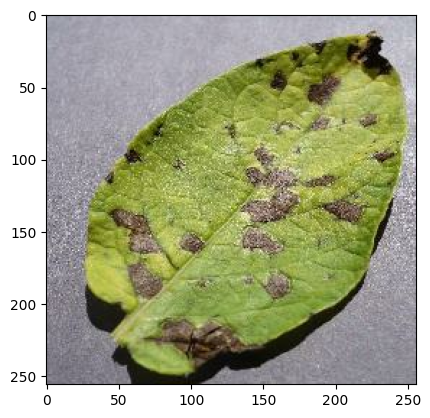

In [31]:
for images_batch,labels_batch in test_ds.take(1):
    first_img=images_batch[0].numpy().astype('uint8')
    first_labels=label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_img)
    print("first image 's actual label:",class_names[first_labels])
    batch_prediction=model.predict(images_batch)
    print(batch_prediction)

    


In [32]:
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)  

    # Expand dimensions to create a batch of size 1
    img_array = tf.expand_dims(img_array, axis=0)  # Add an axis at position 0

    # Make predictions using the model
    predictions = model.predict(img_array)

    # Get the predicted class label
    predicted_class = class_names[np.argmax(predictions[0])]  # Get the index of the highest prediction

    # Calculate the confidence level of the prediction
    confidence = round(100 * np.max(predictions[0]), 2)  # Maximum prediction value converted to percentage

    return predicted_class, confidence  # Return the predicted class and confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


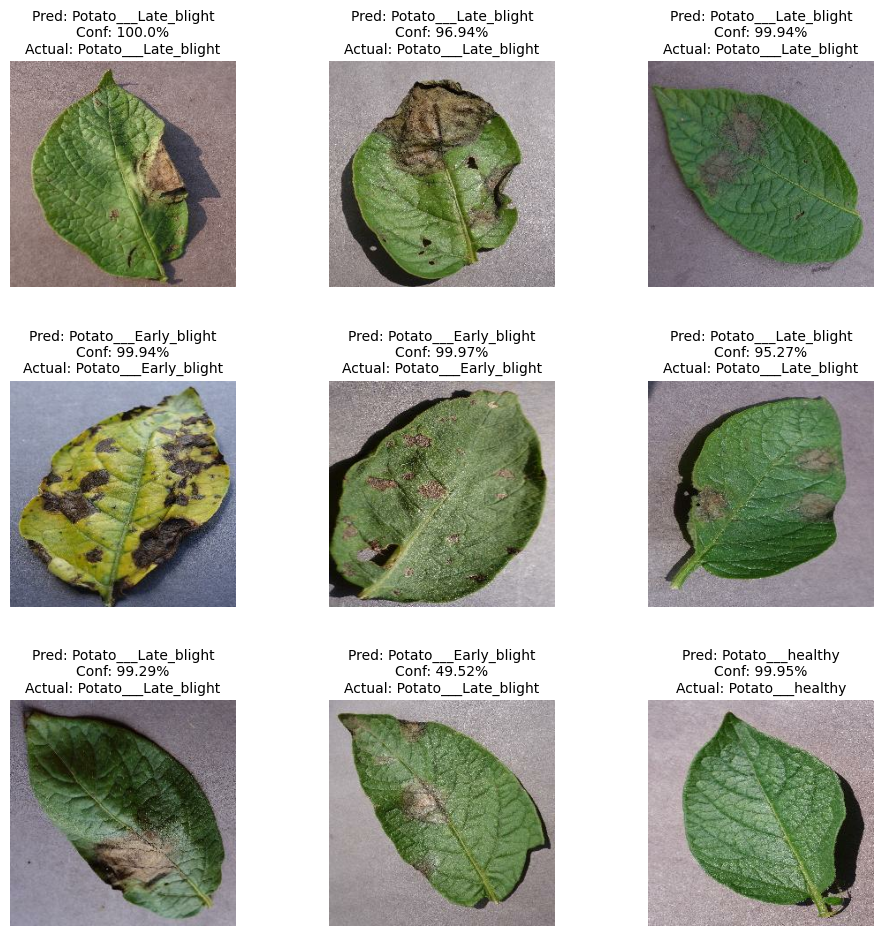

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Take one batch of images and labels from the test dataset
for images, labels in test_ds.take(1):
    plt.figure(figsize=(10, 10))  # Set the figure size for better visibility
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        plt.axis("off")  # Turn off the axis

        # Predict the class and confidence for the current image
        predicted_class, confidence = predict(model, images[i].numpy())

        # Get the actual class from labels (ensure it is converted to the correct class name)
        actual_class = class_names[labels[i].numpy()]  # Convert tensor to numpy

        # Set the title of the subplot to show predicted and actual class with confidence
        plt.title(f"Pred: {predicted_class}\nConf: {confidence}%\nActual: {actual_class}", fontsize=10)

    plt.tight_layout(pad=3.0)  # Adjust layout for better spacing
    plt.show()  # Display the plot


In [40]:
import os

# Define the model version
model_version = 1

# Create a new folder for the model if it doesn't exist
model_dir = f"models/model_version_{model_version}"
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model with the .keras extension
model.save(os.path.join(model_dir, f"model_version_{model_version}.keras"))  # Save the model
